<a href="https://www.kaggle.com/code/taimour/automl-h2o-feature-engineering-piu?scriptVersionId=204708891" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# <div style="text-align:center"><span style="background-color:#a8edc4;color:black;padding:10px;border-radius:40px;">🌐 AutoML H2O</span></div>


![](https://i.postimg.cc/Jz5DS0dq/pexels-james-frid-81279-9823161.jpg)

# <span style="background-color:#bbebfa;color:black;padding:10px;border-radius:40px;">❗Understanding the Competition</span>
<div style="background-color:white;color:black;padding:10px;border:20px groove brown;border-radius:40px;">
  <h2 style="color:black;">Aim of competition</h2>
  <p style="color:black;">This competition aimed to predict the severity of Problematic Internet Use (PIU) in children and adolescents based on their physical activity and fitness data.</p>

  <h2 style="color:black;">Key Points:</h2>
  <ul>
    <li><strong>Data</strong>: The competition utilized data from the Healthy Brain Network study, including:
      <ul>
        <li>Wrist-worn accelerometer data</li>
        <li>Fitness assessments</li>
        <li>Questionnaires</li>
      </ul>
    </li>
    <li><strong>Target Variable</strong>: Severity Impairment Index (SII), a standard measure of PIU.</li>
    <li><strong>Challenge</strong>: The dataset had missing values, particularly for the target variable SII</li>
    <li><strong>Impact</strong>: Successful models could potentially help identify individuals at risk of PIU and enable early intervention strategies.</li>
  </ul>
</div>

# <span style="background-color:#bbebfa;color:black;padding:10px;border-radius:40px;">🎒 Import Libraries</span>

In [1]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from scipy.optimize import minimize
import os
from tqdm import tqdm
from IPython.display import clear_output
from concurrent.futures import ThreadPoolExecutor
from sklearn.preprocessing import StandardScaler, LabelEncoder
import h2o
from h2o.automl import H2OAutoML
from sklearn.base import clone
from sklearn.metrics import *
from colorama import Fore, Style

SEED = 42
n_splits = 5

# <span style="background-color:#edc8a8;color:black;padding:10px;border-radius:40px;">📑 Explaining: Python Modules</span>

<div style="background-color:white;color:black;padding:10px;border:20px groove brown;border-radius:40px;">
  <h2 style="color:black;">Imported Modules</h2>
  <ul>
    <li><strong>NumPy (np):</strong> For numerical computations</li>
    <li><strong>Pandas (pd):</strong> For data analysis and manipulation</li>
    <li><strong>Seaborn (sns):</strong> For visualization</li>
    <li><strong>matplotlib.pyplot (plt):</strong> For plotting</li>
    <li><strong>StratifiedKFold (sklearn.model_selection):</strong> For stratified K-Fold cross-validation</li>
    <li><strong>SciPy.optimize (scipy.optimize):</strong> For optimization routines</li>
    <li><strong>OS:</strong> For operating system interactions</li>
    <li><strong>TQDM:</strong> For progress bar visualization</li>
    <li><strong>IPython.display:</strong> For displaying output in Jupyter notebooks</li>
    <li><strong>Concurrent.futures (concurrent.futures):</strong> For parallel execution of tasks</li>
    <li><strong>StandardScaler (sklearn.preprocessing):</strong> For feature standardization</li>
    <li><strong>LabelEncoder (sklearn.preprocessing):</strong> For encoding categorical features</li>
    <li><strong>H2O (h2o):</strong> For distributed machine learning platform</li>
    <li><strong>Sklearn.base (sklearn.base):</strong> For base classes for estimators</li>
    <li><strong>Sklearn.metrics (sklearn.metrics):</strong> For calculating metrics</li>
    <li><strong>Colorama (colorama):</strong> For colored text output</li>
  </ul>

  <h2 style="color:black;">Global Variables</h2>
  <ul>
    <li><strong>SEED (integer):</strong> Random seed for reproducibility</li>
    <li><strong>n_splits (integer):</strong> Number of folds</li>
  </ul>
</div>

# <span style="background-color:#bbebfa;color:black;padding:10px;border-radius:40px;">📤 Load CSV Files</span>

In [2]:
train_df = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/train.csv')
sample = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/sample_submission.csv')

TARGET_COLS = [
    "PCIAT-Season",
    "PCIAT-PCIAT_01",
    "PCIAT-PCIAT_02",
    "PCIAT-PCIAT_03",
    "PCIAT-PCIAT_04",
    "PCIAT-PCIAT_05",
    "PCIAT-PCIAT_06",
    "PCIAT-PCIAT_07",
    "PCIAT-PCIAT_08",
    "PCIAT-PCIAT_09",
    "PCIAT-PCIAT_10",
    "PCIAT-PCIAT_11",
    "PCIAT-PCIAT_12",
    "PCIAT-PCIAT_13",
    "PCIAT-PCIAT_14",
    "PCIAT-PCIAT_15",
    "PCIAT-PCIAT_16",    
    "PCIAT-PCIAT_17",
    "PCIAT-PCIAT_18",
    "PCIAT-PCIAT_19",
    "PCIAT-PCIAT_20",
    "PCIAT-PCIAT_Total"
]

train_df = train_df.drop(TARGET_COLS,axis=1)

test_df = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/test.csv')
ids = test_df['id']

SEASON_COLS = [
    "Basic_Demos-Enroll_Season", "CGAS-Season", "Physical-Season",
    "Fitness_Endurance-Season", "FGC-Season", "BIA-Season",
    "PAQ_A-Season", "PAQ_C-Season", "SDS-Season", "PreInt_EduHx-Season"
]

train_df = train_df.drop(SEASON_COLS,axis=1)
test_df = test_df.drop(SEASON_COLS,axis=1)

# <span style="background-color:#edc8a8;color:black;padding:10px;border-radius:40px;">📑 Explaining: Load CSV Files</span>

<div style="background-color:white;color:black !important;padding:10px;border:20px groove brown;border-radius:40px;">
  <h2 style="color:black;">Data Loading</h2>
  <ul>
    <li><strong>train_df</strong> is loaded from the specified CSV file containing the training data.</li>
    <li><strong>sample</strong> is loaded from the specified CSV file containing the sample submission data.</li>
  </ul>

  <h2 style="color:black;">Target Columns</h2>
  <ul><li>A list of target columns (<strong>TARGET_COLS</strong>) is defined, containing the PCIAT columns that will be removed.</li></ul>

<h2 style="color:black;">Dropping Target Columns</h2>
<ul>
    <li>The target columns are dropped from the training data (<strong>train_df</strong>) to remove features that are not in test data.</li></ul>

<h2 style="color:black;">Loading Test Data and Extracting IDs</h2>
<ul><li>The test data (<strong>test_df</strong>) is loaded from the test CSV file.</li> 
    <li>The "id" column is extracted from the test data and stored in the <strong>ids</strong> variable.</li></ul>
<h2 style="color:black;">Season Columns</h2>
  <ul><li>A list of season columns (<strong>SEASON_COLS</strong>) is defined, containing the season columns that will be removed.</li></ul>

</div>

# <span style="background-color:#bbebfa;color:black;padding:10px;border-radius:40px;">📤 Load Parquet Files</span>

In [3]:
def process_file(filename, dirname):
    df = pd.read_parquet(os.path.join(dirname, filename, 'part-0.parquet'))
    df.drop('step', axis=1, inplace=True)
    return df.describe().values.reshape(-1), filename.split('=')[1]

def load_time_series(dirname) -> pd.DataFrame:
    ids = os.listdir(dirname)
    
    with ThreadPoolExecutor() as executor:
        results = list(tqdm(executor.map(lambda fname: process_file(fname, dirname), ids), total=len(ids)))
    
    stats, indexes = zip(*results)
    
    df = pd.DataFrame(stats, columns=[f"Stat_{i}" for i in range(len(stats[0]))])
    df['id'] = indexes
    
    return df

train_ts = load_time_series("/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet")
test_ts = load_time_series("/kaggle/input/child-mind-institute-problematic-internet-use/series_test.parquet")
time_series_cols = train_ts.columns.tolist()
time_series_cols.remove("id")

100%|██████████| 2/2 [00:00<00:00,  9.17it/s]


# <span style="background-color:#edc8a8;color:black;padding:10px;border-radius:40px;">📑 Explaining: Load Parquet Files</span>

<div style="background-color:white;color:black;padding:10px;border:20px groove brown;border-radius:40px;">

  <h2 style="color:black;">Process Function (<strong>process_file</strong>)</h2>

  <ul>
    <li>Reads the Parquet file using <strong>pd.read_parquet</strong>.</li>
    <li>Drops the "step" column (assuming it's not relevant for the analysis).</li>
    <li>Calculates descriptive statistics for the remaining columns and reshapes the results into a one-dimensional array.</li>
    <li>Extracts the ID from the filename (assuming the format filename=ID.parquet) and returns a tuple containing the statistics and the ID.</li>
  </ul>

  <h2 style="color:black;">Load Time Series (<strong>load_time_series</strong>)</h2>

  <ul>
    <li>It lists all files (assumed to be time series data) in the directory using <strong>os.listdir(dirname)</strong>. </li>
    <li>It utilizes a <strong>ThreadPoolExecutor</strong> for parallel processing to improve efficiency.</li>
    <ul>
      <li>The <strong>executor.map</strong> function applies the <strong>process_file</strong> function to each filename asynchronously.</li>
      <li>A progress bar (<strong>tqdm</strong>) is used to visualize the progress of processing files.</li>
    </ul>
    <li>It unpacks the results obtained from parallel processing into separate lists for statistics (<strong>stats</strong>) and IDs (<strong>indexes</strong>).</li>
    <li>It creates a DataFrame (<strong>df</strong>) from the statistics, with column names generated as "Stat_i" for each statistic index (<strong>i</strong>).</li>
    <li>It adds a new column named "id" to the DataFrame containing the extracted IDs.</li>
    <li>Finally, it returns the DataFrame containing the processed time series data.</li>
  </ul>

  <h2 style="color:black;">Loading Training and Test Time Series</h2>
  <ul>
    <li>The <strong>load_time_series</strong> function is used to load time series data from training and test directories, respectively.</li> 
        <li>The resulting DataFrames are stored in <strong>train_ts</strong> and <strong>test_ts</strong>.</li>
    <li>Time series feature columns are extracted from the training data columns (<strong>time_series_cols</strong>) by removing the "id" column.</li>
  </ul>
</div>

# <span style="background-color:#bbebfa;color:black;padding:10px;border-radius:40px;">🗒️ Merge CSV & Parquet</span>

In [4]:
train = pd.merge(train_df, train_ts, how="left", on='id')
test = pd.merge(test_df, test_ts, how="left", on='id')

train = train.drop('id', axis=1)
test = test.drop('id', axis=1)
train = train.dropna(subset=['sii'])

# <span style="background-color:#edc8a8;color:black;padding:10px;border-radius:40px;">📑 Explaining: Merge CSV & Parquet</span>

<div style="background-color:white;color:black;padding:10px;border:20px groove brown;border-radius:40px;">
  <h2 style="color:black;">Merging Tabular and Time Series Data</h2>
  <ul>
    <li><strong>train_df</strong> and <strong>train_ts</strong> are merged based on the "id" column using a left join.</li>
    <li><strong>test_df</strong> and <strong>test_ts</strong> are merged based on the "id" column using a left join.</li>
  </ul>

  <h2 style="color:black;">Dropping Unnecessary Column</h2>
  <ul>
    <li>The "id" column is dropped from both the training and testing DataFrames as it is no longer needed for model training.</li>
  </ul>

  <h2 style="color:black;">Handling Missing Values</h2>
  <ul>
    <li>Rows with missing values in the "sii" column (i.e target variable) are dropped from the training DataFrame.</li>
  </ul>
</div>

# <span style="background-color:#bbebfa;color:black;padding:10px;border-radius:40px;">✨ Preprocessing</span>

In [5]:
def preprocess_data(df,train_data=False):
    # Handle numerical columns
    num_cols = df.select_dtypes(include=np.number).columns
    df[num_cols] = df[num_cols].fillna(df[num_cols].median())
    
    return df

train = preprocess_data(train)
test = preprocess_data(test)

train = pd.DataFrame(train)
test = pd.DataFrame(test)

# <span style="background-color:#edc8a8;color:black;padding:10px;border-radius:40px;">📑 Explaining: Preprocessing</span>
<div style="background-color:white;color:black;padding:10px;border:20px groove brown;border-radius:40px;">
  <h2 style="color:black;">Data Preprocessing and Feature Engineering</h2>

  <p style="color:black;">This code snippet defines a function: <strong>preprocess_data</strong> to handle categorical and numerical features, respectively.</p>

  <h3 style="color:black;">Preprocessing Data</h3>
  <p style="color:black;">The <strong>preprocess_data</strong> function performs the following steps:</p>
  <ul>
    <li><strong>Handling Numerical Features</strong>
      <ul>
        <li>Identifies numerical columns using <strong>df.select_dtypes(include=np.number).columns</strong>.</li>
        <li>Fills missing values in numerical columns with the median value using <strong>df[num_cols].fillna(df[num_cols].median())</strong>.</li>
      </ul>
    </li>
  </ul>

  <p style="color:black;">Finally, the preprocessed training and testing DataFrames are converted back to Pandas DataFrames.</p>
</div>

# <span style="background-color:#bbebfa;color:black;padding:10px;border-radius:40px;">⚙️ Feature Engineering</span>

In [6]:
def feature_engineering(df):
    df['Physical-BMI_Height_Ratio'] = df['Physical-BMI'] / df['Physical-Height']
    df['Physical-Weight_Height_Ratio'] = df['Physical-Weight'] / df['Physical-Height']
    df['Physical-BMI_Squared'] = df['Physical-BMI'] ** 2
    df['Physical-Height_Squared'] = df['Physical-Height'] ** 2
    df['Physical-Weight_Squared'] = df['Physical-Weight'] ** 2
    df['Physical-HeartRate_Squared'] = df['Physical-HeartRate'] ** 2
    df['Basic_Demos-Age_Squared'] = df['Basic_Demos-Age'] ** 2
    df['SDS-SDS_Total_Raw_Squared'] = df['SDS-SDS_Total_Raw'] ** 2
    df['SDS-SDS_Total_T_Squared'] = df['SDS-SDS_Total_T'] ** 2
    df['PreInt_EduHx-computerinternet_hoursday_Squared'] = df['PreInt_EduHx-computerinternet_hoursday'] ** 2
    return df

train = feature_engineering(train)
test = feature_engineering(test)

/tmp/ipykernel_17/918004536.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['Physical-BMI_Height_Ratio'] = df['Physical-BMI'] / df['Physical-Height']
/tmp/ipykernel_17/918004536.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['Physical-Weight_Height_Ratio'] = df['Physical-Weight'] / df['Physical-Height']
/tmp/ipykernel_17/918004536.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at o

# <span style="background-color:#edc8a8;color:black;padding:10px;border-radius:40px;">📑 Explaining: Feature Engineering</span>

<div style="background-color:white;color:black;padding:10px;border:20px groove brown;border-radius:40px;">
  <h2 style="color:black;">Creating New Features</h2>
  <ul>
    <li>Feature engineering improves model performance by creating informative features, reducing model complexity, enhancing interpretability, and potentially speeding up training.</li>
    <li>It helps models generalize better and capture domain-specific insights.</li>
  </ul>
</div>

# <span style="background-color:#bbebfa;color:black;padding:10px;border-radius:40px;">🔎 View Data</span>

In [7]:
train.head()

,Basic_Demos-Age,Basic_Demos-Sex,CGAS-CGAS_Score,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,...,Physical-BMI_Height_Ratio,Physical-Weight_Height_Ratio,Physical-BMI_Squared,Physical-Height_Squared,Physical-Weight_Squared,Physical-HeartRate_Squared,Basic_Demos-Age_Squared,SDS-SDS_Total_Raw_Squared,SDS-SDS_Total_T_Squared,PreInt_EduHx-computerinternet_hoursday_Squared
0,5,0,51.0,16.877316,46.0,50.8,26.0,68.0,81.0,114.0,...,0.366898,1.104348,284.843785,2116.00,2580.64,6561.0,25,1521.0,3025.0,9.0
1,9,0,65.0,14.035590,48.0,46.0,22.0,75.0,70.0,122.0,...,0.292408,0.958333,196.997795,2304.00,2116.00,4900.0,81,2116.0,4096.0,0.0
2,10,1,71.0,16.648696,56.5,75.6,26.0,65.0,94.0,117.0,...,0.294667,1.338053,277.179080,3192.25,5715.36,8836.0,100,1444.0,2916.0,4.0
3,9,0,71.0,18.292347,56.0,81.6,26.0,60.0,97.0,117.0,...,0.326649,1.457143,334.609957,3136.00,6658.56,9409.0,81,961.0,2025.0,0.0
5,13,1,50.0,22.279952,59.5,112.2,26.0,60.0,73.0,102.0,...,0.374453,1.885714,496.396260,3540.25,12588.84,5329.0,169,1600.0,3136.0,0.0


In [8]:
test.head()

,Basic_Demos-Age,Basic_Demos-Sex,CGAS-CGAS_Score,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,...,Physical-BMI_Height_Ratio,Physical-Weight_Height_Ratio,Physical-BMI_Squared,Physical-Height_Squared,Physical-Weight_Squared,Physical-HeartRate_Squared,Basic_Demos-Age_Squared,SDS-SDS_Total_Raw_Squared,SDS-SDS_Total_T_Squared,PreInt_EduHx-computerinternet_hoursday_Squared
0,5,0,51.0,16.877316,46.0,50.8,24.0,63.0,80.0,116.0,...,0.366898,1.104348,284.843785,2116.00,2580.64,6400.0,25,1406.25,2862.25,9.0
1,9,0,63.0,14.035590,48.0,46.0,22.0,75.0,70.0,122.0,...,0.292408,0.958333,196.997795,2304.00,2116.00,4900.0,81,2116.00,4096.00,0.0
2,10,1,71.0,16.648696,56.5,75.6,24.0,65.0,94.0,117.0,...,0.294667,1.338053,277.179080,3192.25,5715.36,8836.0,100,1444.00,2916.00,4.0
3,9,0,71.0,18.292347,56.0,81.6,24.0,60.0,97.0,117.0,...,0.326649,1.457143,334.609957,3136.00,6658.56,9409.0,81,961.00,2025.00,0.0
4,18,1,63.0,18.292347,55.0,81.6,24.0,63.0,80.0,116.0,...,0.332588,1.483636,334.609957,3025.00,6658.56,6400.0,324,1406.25,2862.25,4.0


# <span style="background-color:#edc8a8;color:black;padding:10px;border-radius:40px;">📑 Explaining: View Data</span>

<div style="background-color:white;color:black;padding:10px;border:20px groove brown;border-radius:40px;">
  <h2 style="color:black;">Displaying First Few Rows of DataFrames</h2>
  <ul>
    <li>Use the <strong>head()</strong> method to display the first few rows of the preprocessed training and testing DataFrames.</li>
    <li>This provides insights into the data structure, column names, and values.</li>
  </ul>
</div>

# <span style="background-color:#bbebfa;color:black;padding:10px;border-radius:40px;">⚖️ Quadratic Weighted Kappa</span>

In [9]:
def quadratic_weighted_kappa(y_true, y_pred):
    return cohen_kappa_score(y_true, y_pred, weights='quadratic')

def threshold_Rounder(oof_non_rounded, thresholds):
    return np.where(oof_non_rounded < thresholds[0], 0,
                    np.where(oof_non_rounded < thresholds[1], 1,
                             np.where(oof_non_rounded < thresholds[2], 2, 3)))

def evaluate_predictions(thresholds, y_true, oof_non_rounded):
    rounded_p = threshold_Rounder(oof_non_rounded, thresholds)
    return -quadratic_weighted_kappa(y_true, rounded_p)

def TrainML(model_class, test_data, train_data):
    X = train_data.drop(['sii'], axis=1)
    y = train_data['sii']

    SKF = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)
    
    train_S = []
    test_S = []
    
    oof_non_rounded = np.zeros(len(y), dtype=float) 
    oof_rounded = np.zeros(len(y), dtype=int) 
    test_preds = np.zeros((len(test_data), n_splits))

    for fold, (train_idx, test_idx) in enumerate(tqdm(SKF.split(X, y), desc="Training Folds", total=n_splits)):
        X_train, X_val = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[test_idx]

        X_train = h2o.H2OFrame(X_train)
        y_train_pred = best_model.predict(X_train)
        y_train_pred = y_train_pred.as_data_frame()
        y_train_pred = y_train_pred.values
        y_train_pred = y_train_pred.reshape(-1)
        
        X_val = h2o.H2OFrame(X_val)
        y_val_pred = best_model.predict(X_val)
        y_val_pred = y_val_pred.as_data_frame()
        y_val_pred = y_val_pred.values
        y_val_pred = y_val_pred.reshape(-1)

        oof_non_rounded[test_idx] = y_val_pred
        y_val_pred_rounded = y_val_pred.round(0).astype(int)
        oof_rounded[test_idx] = y_val_pred_rounded

        train_kappa = quadratic_weighted_kappa(y_train, y_train_pred.round(0).astype(int))
        val_kappa = quadratic_weighted_kappa(y_val, y_val_pred_rounded)

        train_S.append(train_kappa)
        test_S.append(val_kappa)
        
        test_data_copy = h2o.H2OFrame(test_data)
        test_data_copy = best_model.predict(test_data_copy)
        test_data_copy = test_data_copy.as_data_frame()
        test_data_copy = test_data_copy.values
        test_data_copy = test_data_copy.reshape(-1)
        test_preds[:, fold] = test_data_copy        
        
        print(f"Fold {fold+1} - Train QWK: {train_kappa:.4f}, Validation QWK: {val_kappa:.4f}")
        clear_output(wait=True)

    print(f"Mean Train QWK --> {np.mean(train_S):.4f}")
    print(f"Mean Validation QWK ---> {np.mean(test_S):.4f}")

    KappaOPtimizer = minimize(evaluate_predictions, x0=[0.58, 0.99, 2.68], args=(y, oof_non_rounded), method='Nelder-Mead') # Nelder-Mead | # Powell
    assert KappaOPtimizer.success, "Optimization did not converge."
    
    oof_tuned = threshold_Rounder(oof_non_rounded, KappaOPtimizer.x)
    tKappa = quadratic_weighted_kappa(y, oof_tuned)

    print(f"----> || Optimized QWK SCORE :: {Fore.CYAN}{Style.BRIGHT} {tKappa:.3f}{Style.RESET_ALL}")

    tpm = test_preds.mean(axis=1)
    tpTuned = threshold_Rounder(tpm, KappaOPtimizer.x)
    
    submission = pd.DataFrame({
        'id': sample['id'],
        'sii': tpTuned
    })

    return submission,KappaOPtimizer

# <span style="background-color:#edc8a8;color:black;padding:10px;border-radius:40px;">📑 Explaining: Quadratic Weighted Kappa</span>

<div style="background-color:white;color:black;padding:10px;border:20px groove brown;border-radius:40px;">
  <h2 style="color:black;">Quadratic Weighted Kappa and Training Function</h2>

  <p style="color:black;">This section defines two functions: <strong>quadratic_weighted_kappa</strong> and <strong>TrainML</strong>.</p>

  <h3 style="color:black;">quadratic_weighted_kappa</h3>
  <ul><li>This function calculates the quadratic weighted kappa score between two sets of labels (<strong>y_true</strong> and <strong>y_pred</strong>).</li><li> It utilizes the <strong>cohen_kappa_score</strong> function from scikit-learn with the <strong>weights='quadratic'</strong> argument.</li></ul>

  <h3 style="color:black;">TrainML</h3>
  <p style="color:black;">This function is responsible for training a machine learning model and evaluating its performance. It takes the model class (<strong>model_class</strong>), testing data (<strong>test_data</strong>), and training data (<strong>train_data</strong>) as input.</p>

  <ul>
    <li>It separates the target variable (<strong>sii</strong>) from the features in the training data (<strong>X</strong> and <strong>y</strong>).</li>
    <li>It uses <strong>StratifiedKFold</strong> to perform stratified K-Fold cross-validation, ensuring balanced class distribution in each fold.</li>
    <li>It initializes arrays to store training and validation kappa scores (<strong>train_S</strong>, <strong>test_S</strong>), predicted probabilities (<strong>oof_non_rounded</strong>), rounded predictions (<strong>oof_rounded</strong>), and test set predictions (<strong>test_preds</strong>).</li>
    <li>It iterates through each fold using a progress bar (<strong>tqdm</strong>).</li>
      <ul>
        <li>Within each fold, it splits the training data into training and validation sets (<strong>X_train</strong>, <strong>X_val</strong>, <strong>y_train</strong>, <strong>y_val</strong>).</li>
        <li>It converts the training and validation sets to H2O Frames.</li>
        <li>It uses the <strong>best_model</strong> to predict probabilities for both the training and validation sets.</li>
        <li>It converts the H2OFrame predictions to NumPy arrays.</li>
        <li>It stores the predicted probabilities for the validation set (<strong>oof_non_rounded</strong>) and rounds them to integers for evaluation (<strong>oof_rounded</strong>).</li>
        <li>It calculates and stores the quadratic weighted kappa scores for the training and validation sets (<strong>train_kappa</strong>, <strong>val_kappa</strong>).</li>
        <li>It appends these kappa scores to their respective lists (<strong>train_S</strong>, <strong>test_S</strong>).</li>
        <li>It converts the test data to an H2O Frame.</li>
        <li>It uses the <strong>best_model</strong> to predict probabilities for the test data.</li>
        <li>It converts the H2OFrame predictions to a NumPy array and stores them in <strong>test_preds[:, fold]</strong>.</li>
        <li>It prints the fold number, training kappa score, and validation kappa score.</li>
      </ul>
    <li>It prints the mean training and validation kappa scores.</li>
    <li>It performs optimization using <strong>minimize</strong> to find the optimal thresholds for rounding the predicted probabilities. This optimization minimizes the negative quadratic weighted kappa (<strong>evaluate_predictions</strong>) on the validation set (<strong>y</strong>, <strong>oof_non_rounded</strong>). The Nelder-Mead method is used for optimization.</li>
    <li>It asserts that the optimization converged successfully.</li>
    <li>It applies the optimized thresholds to the validation set probabilities (<strong>oof_tuned</strong>) and calculates the final kappa score (<strong>tKappa</strong>).</li>
    <li>It prints the optimized kappa score.</li>
    <li>It calculates the mean of the predicted probabilities across all folds for the test set (<strong>tpm</strong>).</li>
    <li>It applies the optimized thresholds to the mean test set probabilities (<strong>tpTuned</strong>).</li>
    <li>Finally, it creates a submission DataFrame with the IDs from the sample data and the rounded predictions (<strong>tpTuned</strong>) and returns this DataFrame along with the trained model.</li>
  </ul>
</div>

# <span style="background-color:#bbebfa;color:black;padding:10px;border-radius:40px;">🌐 AutoML H2O</span>

In [10]:
h2o.init()
train_data = h2o.H2OFrame(train)

aml = H2OAutoML(max_runtime_secs=5400,seed=5)
aml.train(y='sii', training_frame=train_data)

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.24" 2024-07-16; OpenJDK Runtime Environment (build 11.0.24+8-post-Ubuntu-1ubuntu320.04); OpenJDK 64-Bit Server VM (build 11.0.24+8-post-Ubuntu-1ubuntu320.04, mixed mode, sharing)
  Starting server from /opt/conda/lib/python3.10/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpc8kr94zo
  JVM stdout: /tmp/tmpc8kr94zo/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpc8kr94zo/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.5
H2O_cluster_version_age:,2 months and 3 days
H2O_cluster_name:,H2O_from_python_unknownUser_u3o93n
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.500 Gb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |
17:09:38.263: _train param, Dropping bad and constant columns: [Stat_41, Stat_42]

██
17:09:52.763: _train param, Dropping bad and constant columns: [Stat_41, Stat_42]


17:09:56.543: _train param, Dropping bad and constant columns: [Stat_41, Stat_42]

██
17:10:07.657: _train param, Dropping unused columns: [Stat_41, Stat_42]
17:10:08.19: _train param, Dropping bad and constant columns: [Stat_41, Stat_42]

█
17:10:16.590: _train param, Dropping bad and constant columns: [Stat_41, Stat_42]

██
17:10:42.162: _train param, Dropping bad and constant columns: [Stat_41, Stat_42]

█
17:10:50.210: _train param, Dropping bad and constant columns: [Stat_41, Stat_42]


17:10:58.610: _train param, Dropping bad and constant columns: [Stat_41, Stat_42]

██
17:11:09.167: _train param, Dropping unused columns: [Stat_41, Stat_42]
17:11:09.638: _train param, Dropping unused columns: [Stat_41

key,value
Stacking strategy,cross_validation
Number of base models (used / total),4/6
# GBM base models (used / total),1/1
# XGBoost base models (used / total),1/1
# DeepLearning base models (used / total),1/1
# DRF base models (used / total),1/2
# GLM base models (used / total),0/1
Metalearner algorithm,GLM
Metalearner fold assignment scheme,Random
Metalearner nfolds,5


# <span style="background-color:#edc8a8;color:black;padding:10px;border-radius:40px;">📑 Explaining: AutoML H2O</span>

<div style="background-color:white;color:black;padding:10px;border:20px groove brown;border-radius:40px;">
  <h2 style="color:black;">Initializing H2O and Training an AutoML Model</h2>

  <p style="color:black;">This code snippet initializes the H2O environment and trains an AutoML model on the training data.</p>

  <ul>
    <li><strong>h2o.init()</strong>: Initializes the H2O cluster.</li>
    <li><strong>train_data = h2o.H2OFrame(train)</strong>: Converts the Pandas DataFrame <strong>train</strong> into an H2OFrame for use with H2O algorithms.</li>
    <li><strong>aml = H2OAutoML(max_runtime_secs, seed)</strong>: Creates an AutoML instance with a maximum runtime in seconds and a random seed of 5.</li>
    <li><strong>aml.train(y='sii', training_frame=train_data)</strong>: Trains the AutoML model on the <strong>train_data</strong> with <strong>sii</strong> as the target variable.</li>
  </ul>
</div>

# <span style="background-color:#bbebfa;color:black;padding:10px;border-radius:40px;">⭐ Variable Importance</span>

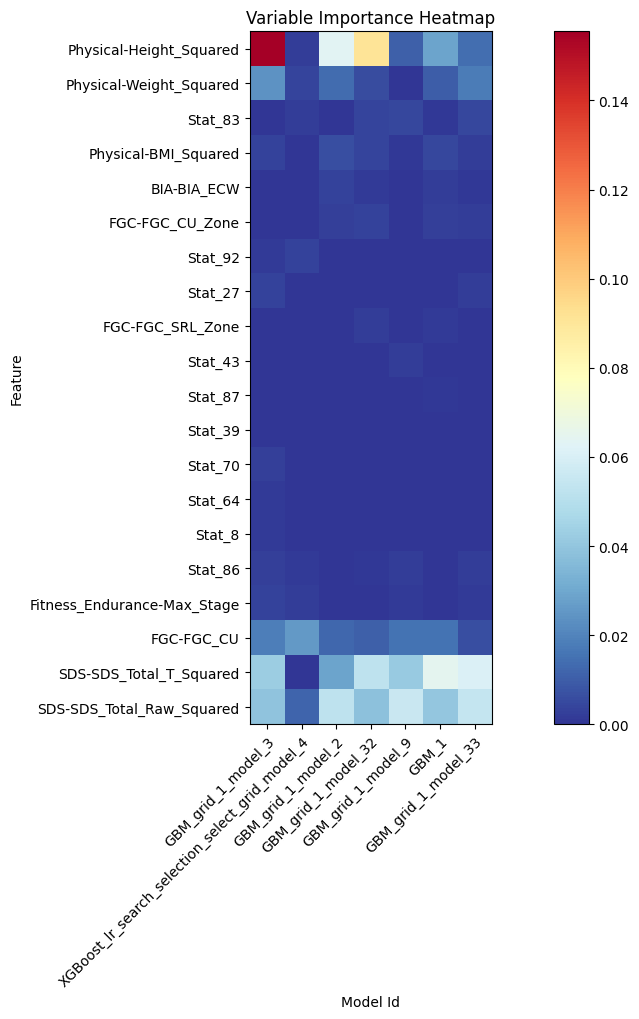

In [11]:
varimp_heatmap = aml.varimp_heatmap()
varimp_heatmap

In [12]:
leader = aml.leader
leader

key,value
Stacking strategy,cross_validation
Number of base models (used / total),4/6
# GBM base models (used / total),1/1
# XGBoost base models (used / total),1/1
# DeepLearning base models (used / total),1/1
# DRF base models (used / total),1/2
# GLM base models (used / total),0/1
Metalearner algorithm,GLM
Metalearner fold assignment scheme,Random
Metalearner nfolds,5


# <span style="background-color:#edc8a8;color:black;padding:10px;border-radius:40px;">📑 Explaining: Variable Importance</span>

<div style="background-color:white;color:black;padding:10px;border:20px groove brown;border-radius:40px;">
  <h2 style="color:black;">Importance of Variables</h2>

  <ul>
      <li>The <strong>variable importance heatmap</strong> shows importance of different variables with respect to different models.</li>
      <li><strong>aml.leader</strong> shows model details, summary, history and variable importances</li>
    </ul>

</div>

# <span style="background-color:#bbebfa;color:black;padding:10px;border-radius:40px;">🏆 Leaderboard</span>

In [13]:
leaderboard = aml.leaderboard
leaderboard

model_id,rmse,mse,mae,rmsle,mean_residual_deviance
StackedEnsemble_BestOfFamily_7_AutoML_1_20241101_170938,0.669014,0.44758,0.530801,0.390972,0.44758
StackedEnsemble_BestOfFamily_8_AutoML_1_20241101_170938,0.669068,0.447651,0.530151,0.391468,0.447651
StackedEnsemble_BestOfFamily_5_AutoML_1_20241101_170938,0.669239,0.447881,0.529053,0.391285,0.447881
StackedEnsemble_BestOfFamily_4_AutoML_1_20241101_170938,0.669493,0.448221,0.528836,0.391546,0.448221
StackedEnsemble_AllModels_6_AutoML_1_20241101_170938,0.669513,0.448247,0.531106,0.391642,0.448247
StackedEnsemble_AllModels_2_AutoML_1_20241101_170938,0.66967,0.448458,0.530513,0.391537,0.448458
GBM_grid_1_AutoML_1_20241101_170938_model_33,0.66975,0.448565,0.535962,0.392449,0.448565
StackedEnsemble_AllModels_3_AutoML_1_20241101_170938,0.66982,0.448659,0.529869,0.392079,0.448659
StackedEnsemble_Best1000_1_AutoML_1_20241101_170938,0.670044,0.448958,0.529766,0.392035,0.448958
GBM_1_AutoML_1_20241101_170938,0.67005,0.448967,0.533992,0.392009,0.448967


# <span style="background-color:#edc8a8;color:black;padding:10px;border-radius:40px;">📑 Explaining: Leaderboard</span>

<div style="background-color:white;color:black;padding:10px;border:20px groove brown;border-radius:40px;">
  <h2 style="color:black;">Retrieving the AutoML Leaderboard</h2>

  <ul><li>The <strong>leaderboard</strong> attribute of the AutoML object provides a DataFrame containing the performance metrics of the different models trained during the AutoML process.</li></ul>

</div>

# <span style="background-color:#bbebfa;color:black;padding:10px;border-radius:40px;">🥇 Best Models</span>

In [14]:
best_model = aml.leader
Submission,KappaOPtimizer = TrainML(best_model,test,train)
print(KappaOPtimizer.x)

Training Folds: 100%|██████████| 5/5 [00:11<00:00,  2.27s/it]

Mean Train QWK --> 0.5756
Mean Validation QWK ---> 0.5754


----> || Optimized QWK SCORE ::  0.697
[0.58681909 1.00264378 2.70612078]


# <span style="background-color:#edc8a8;color:black;padding:10px;border-radius:40px;">📑 Explaining: Best Models</span>

<div style="background-color:white;color:black;padding:10px;border:20px groove brown;border-radius:40px;">
  <h2 style="color:black;">Selecting the Best Model and Making Predictions</h2>

  <ul>
    <li><strong>best_model = aml.leader</strong>: Selects the best performing model from the AutoML experiment.</li>
    <li><strong>Submission, KappaOPtimizer = TrainML(best_model, test, train)</strong>: Calls the <strong>TrainML</strong> function with the best model, test data, and training data to make predictions on the test set and optimize the threshold for the final predictions.</li>
    <li><strong>print(KappaOPtimizer.x)</strong>: Prints the optimized threshold values.</li>
  </ul>
</div>

# <span style="background-color:#bbebfa;color:black;padding:10px;border-radius:40px;">📁 Prepare Submission CSV</span>

In [15]:
Submission.to_csv('submission.csv', index=False)

# <span style="background-color:#edc8a8;color:black;padding:10px;border-radius:40px;">📑 Explaining: Prepare Submission CSV</span>

<div style="background-color:white;color:black;padding:10px;border:20px groove brown;border-radius:40px;">
  <h2 style="color:black;">Creating the Submission File</h2>

  <ul><li>This step involves creating a CSV file with the predicted values for the test data.</li></ul>
</div>

# <span style="background-color:#bbebfa;color:black;padding:10px;border-radius:40px;">📰 View Results</span>

In [16]:
print(Submission['sii'].value_counts())
Submission.head(20)

sii
1    13
0     6
2     1
Name: count, dtype: int64


,id,sii
0,00008ff9,1
1,000fd460,0
2,00105258,1
3,00115b9f,0
4,0016bb22,1
5,001f3379,1
6,0038ba98,1
7,0068a485,0
8,0069fbed,1
9,0083e397,1


# <span style="background-color:#edc8a8;color:black;padding:10px;border-radius:40px;">📑 Explaining: View Results</span>

<div style="background-color:white;color:black;padding:10px;border:20px groove brown;border-radius:40px;">
  <h2 style="color:black;">Analyzing and Visualizing the Submission</h2>
  <ul>
    <li>Print the frequency of each predicted value in the "sii" column using <strong>Submission['sii'].value_counts()</strong>.</li>
    <li>Display the first 20 rows of the submission DataFrame using <strong>Submission.head(20)</strong>.</li>
  </ul>
</div>